In [23]:
%load_ext autoreload
%autoreload 2
%aimport -jax
%aimport -jaxlib
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(),"..","projects")))
print(sys.path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/Users/daniel/Documents/code/stable_imitation/stanza/notebooks', '/opt/homebrew/Cellar/python@3.11/3.11.3/Frameworks/Python.framework/Versions/3.11/lib/python311.zip', '/opt/homebrew/Cellar/python@3.11/3.11.3/Frameworks/Python.framework/Versions/3.11/lib/python3.11', '/opt/homebrew/Cellar/python@3.11/3.11.3/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload', '', '/Users/daniel/Documents/code/stable_imitation/stanza/.venv/lib/python3.11/site-packages', '/Users/daniel/Documents/code/stable_imitation/stanza', '/Users/daniel/Documents/code/stable_imitation/stanza/projects', '/Users/daniel/Documents/code/stable_imitation/stanza/projects', '/Users/daniel/Documents/code/stable_imitation/stanza/projects', '/Users/daniel/Documents/code/stable_imitation/stanza/projects']


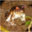

In [24]:
import jax
import jax.numpy as jnp
from stanza.data import Data, PyTreeData
from stanza.util import shape_tree

# dummy data
train_data = Data.from_pytree((jnp.ones((100,32,32,3)), jnp.ones((100, 10))))
test_data = Data.from_pytree((jnp.ones((100,32,32,3)), jnp.ones((100, 10))))
# cifar data
from stanza.data.cifar import cifar10
train_data, test_data = cifar10()
def map_fn(sample):
    x, y = sample
    x = x.astype(float) / 255
    y = jax.nn.one_hot(y, 10)
    return x, y
train_data = PyTreeData.from_data(train_data.map(map_fn))
test_data = PyTreeData.from_data(test_data.map(map_fn))

from stanza.util.ipython import display_image
display_image(train_data[0][0])

In [29]:
import haiku as hk
from jax.random import PRNGKey
import jax
import optax
from stanza import Partial
from stanza.train.rich import RichReporter
from stanza.train import Trainer, SAMTrainer

def run(use_sam=False):
    def net(x):
        flat, _ = jax.flatten_util.ravel_pytree(x)
        mlp = hk.nets.MLP([128,10])
        y = mlp(flat).squeeze()
        y = jax.nn.softmax(y)
        return y
    net = hk.transform(net)
    params = net.init(PRNGKey(42), train_data[0][0])
    @jax.jit
    def loss_fn(params, _state, _rng_key, batch):
        x, y = batch
        y_pred = net.apply(params, None, x)
        loss = jnp.sum(jnp.square(y_pred - y)) 
        return _state, loss, {"loss": loss}
    
    with RichReporter() as r:
        trainer = SAMTrainer(batch_size=128) if use_sam else Trainer(batch_size=128)
        r = trainer.train(Partial(loss_fn), 
            train_data, PRNGKey(42), params, 
            epochs=10, hooks=[r])
run(use_sam=False)

Output()

[21:48:13] TRACE  - <Tracing> Tracing training                                                      ]8;id=815062;file:///Users/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=956373;file:///Users/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#153\153]8;;\

           TRACE  - <Tracing> Tracing epoch step                                                    ]8;id=805815;file:///Users/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=497780;file:///Users/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#117\117]8;;\

           TRACE  - <Tracing> Tracing train step                                                     ]8;id=481070;file:///Users/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=251055;file:///Users/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#76\76]8;;\

           TRACE  - <Tracing> Tracing batch loss                                                     ]8;id=119930;file:///Users/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=789050;file:///Users/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#44\44]8;;\

           TRACE  - <Tracing> Tracing epoch step                                                    ]8;id=458961;file:///Users/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=194661;file:///Users/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#117\117]8;;\

           TRACE  - <Tracing> Done tracing training                                                 ]8;id=625171;file:///Users/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=28122;file:///Users/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#175\175]8;;\

[21:48:15] TRACE  - Starting training                                                               ]8;id=6106;file:///Users/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=158473;file:///Users/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#154\154]8;;\

TypeError: SAMTrainer.train() missing 1 required positional argument: 'init_fn_params'